<a href="https://colab.research.google.com/github/JaredKeithAveritt/AI_methods_in_advanced_materials_research/blob/main/Week_4/pytorch_non_linear_classifier_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework: Train a Nonlinear Classifier

[NonlinearClassifier as we introduced at the end of week 4](https://github.com/JaredKeithAveritt/AI_methods_in_advanced_materials_research/blob/main/Week_4/01_pytorch_mnist.ipynb).


Do the following to train the `NonlinearClassifier` and evaluate its performance on test data, using the following steps:

1. **Initialize the Nonlinear Classifier Model.**
2. **Create Data Loaders for Training and Test Data.**
3. **Define a Loss Function and an Optimizer.**
4. **Train the Model.**
5. **Evaluate the Model on Test Data.**

### Experimenting with Improvements

To improve the model, consider experimenting with:
- **Increasing Model Complexity**: Adding more layers or increasing the number of neurons in existing layers.
- **Changing Activation Functions**: Experimenting with different activation functions like LeakyReLU or ELU.
- **Adjusting the Learning Rate**: Tuning the learning rate or using learning rate schedulers.
- **Using Different Optimizers**: Trying out optimizers like Adam or RMSprop instead of SGD.
- **Implementing Regularization**: Adding dropout layers or using L2 regularization to prevent overfitting.

Remember, compare models using training and validation data. The test data should only be used as a final check to assess generalization capability.



---

# Step 1 -- Dataset Loading and Preprocessing of Input Features

This is the same as from the notebook from week 4.

In [1]:
%matplotlib inline
#This is a magic command (can only use 1 per code block, and must be the first line) for Jupyter notebooks and IPython environments. It ensures that the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The plots will be stored in the notebook document.

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

100%|██████████| 9912422/9912422 [00:00<00:00, 81910317.36it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79589811.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49117151.48it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13895352.86it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

MNIST data loaded: train: 48000 examples, validation: 12000 examples, test: 10000 examples
Input shape: torch.Size([1, 28, 28])


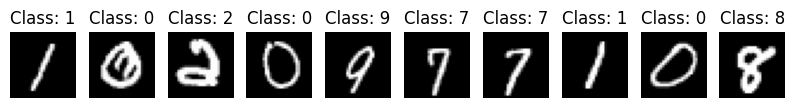

In [3]:



# Load and transform the training data
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Load and transform the test data
# Similar to the training data loader but with 'train=False' to specify that we want to
# load the test (or validation) portion of the MNIST dataset. This data is used to evaluate
# the model's performance on unseen data, providing an estimate of its generalization ability.
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

total_size = len(training_data)  # Total size of the dataset

# Calculate split sizes
train_size = int(total_size * 0.8)  # 80% of the dataset for training
validation_size = total_size - train_size  # Remaining 20% for validation

# Split the dataset into training and validation sets
training_data, validation_data = torch.utils.data.random_split(
    training_data, [train_size, validation_size],
    generator=torch.Generator().manual_seed(55)  # Ensure reproducibility
)

# 'training_data' now contains the training subset,
# 'validation_data' contains the validation subset.

# Print the size of training, validation, and test datasets
print('MNIST data loaded: train:', len(training_data), 'examples,',
      'validation:', len(validation_data), 'examples,',
      'test:', len(test_data), 'examples')

# Print the shape of the input data by accessing the first example in the training dataset
# Note: training_data[0][0] accesses the first image tensor, and .shape retrieves its dimensions
print('Input shape:', training_data[0][0].shape)

pltsize = 1
# Initialize figure with dimensions proportional to the number of images
plt.figure(figsize=(10*pltsize, pltsize))

# Display the first 10 images from the training dataset
for i in range(10):
    plt.subplot(1, 10, i+1)  # Prepare subplot for the ith image
    plt.axis('off')  # Hide the axis for a cleaner look
    # Display the image, reshaping it to 28x28 pixels, in grayscale
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    # Add a title with the class of the digit
    plt.title('Class: '+str(training_data[i][1]))

---
# Step 1: Define Classifier and initialize it
I already did this for you.

In [4]:
class NonlinearClassifier(nn.Module):
    def __init__(self):
        super(NonlinearClassifier, self).__init__()
        # Flatten the input image to a vector
        self.flatten = nn.Flatten()

        # Define a stack of layers: linear transformations followed by ReLU activations
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),  # First layer with 784 inputs and 50 outputs
            nn.ReLU(),  # Nonlinear activation function
            # nn.Dropout(0.2),  # Optional dropout for regularization (commented out)
            nn.Linear(50, 50),  # Second layer, from 50 to 50 neurons
            nn.ReLU(),  # Another ReLU activation
            # nn.Dropout(0.2),  # Another optional dropout layer (commented out)
            nn.Linear(50, 10)   # Final layer that outputs to the 10 classes
        )

    def forward(self, x):
        # Flatten and then pass the data through the layers stack
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x


# Initialize the Nonlinear Classifier Model
nonlinear_model = NonlinearClassifier()

---

# Step 2: Create Data Loaders for Training and Test Data
Assuming `training_data` and `test_data` have already been defined as in previous examples.

Hint: [see the documentation on PyTorch site](https://pytorch.org/docs/stable/data.html)

### Key Components of the Code

- **`DataLoader`**: A class from `torch.utils.data` that provides an iterable over the given dataset. It supports automatic batching, sampling, shuffling, and multiprocess data loading.

- **`batch_size`**: Specifies the number of data samples to be loaded per batch. This is important for controlling memory usage and can significantly affect the training process and model performance.

- **`shuffle`**: A parameter that determines whether the data should be shuffled at every epoch. Shuffling is generally used with the training data to reduce model overfitting by ensuring that batches between epochs do not look similar.

-  No shuffling is applied to the test data loader since the order of evaluation does not affect the final performance metrics.

In [5]:
# Code goes here

from torch.utils.data import DataLoader

# Define the batch size for loading the data, i.e., number of samples per batch
batch_size = 128

# Initialize the DataLoader for the training data
# - training_data: The dataset from which to load the data (must be defined previously)
# - batch_size: The size of each data batch
# - shuffle: Whether to shuffle the data at every epoch, useful for training phase
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

# Initialize the DataLoader for the test data
# Similar to the training dataloader but without shuffling, as it's not needed for evaluation
test_dataloader = DataLoader(test_data, batch_size=batch_size)


---

# Step 3: Define a Loss Function and an Optimizer
The loss function evaluates how well the model's predictions match the target labels, guiding the training process by indicating the model's performance. The optimizer adjusts the model's weights based on the computed gradients to minimize the loss function. This setup is essential for effectively training models to solve various tasks.

### Explanation of Components

- **`nn.CrossEntropyLoss`**: A loss function commonly used for classification tasks. It combines `nn.LogSoftmax` and `nn.NLLLoss` in a single class. This makes it suitable for multi-class classification problems like image classification, where the goal is to categorize inputs into more than two types of classes. It expects outputs to have raw, unnormalized scores (logits) and applies the softmax function internally.

- **`torch.optim.SGD`**: The Stochastic Gradient Descent (SGD) optimizer. It's one of the most basic optimization algorithms used for training neural networks. SGD updates the model's parameters by moving them in the direction of the negative gradient of the loss function, with the step size determined by the learning rate (`lr`).

the loss function and optimizer necessary for training the `nonlinear_model`. The `nn.CrossEntropyLoss` is chosen for its effectiveness in classification tasks, where the model outputs a score for each class, and the correct class is the target. The `SGD` optimizer is a simple yet effective choice for many problems, with the learning rate set to 0.01, balancing the speed and stability of the training process.

In [6]:
# Code goes here

# Initialize the CrossEntropyLoss function
# This loss function is well-suited for classification problems with multiple classes
loss_fn = nn.CrossEntropyLoss()

# Initialize the SGD optimizer for updating the model's parameters
# - nonlinear_model.parameters(): The parameters of the model to be optimized
# - lr=0.01: The learning rate controls the step size in the parameter space search
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)


---

# Step 4: Train your model

Hint: A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.



### Implementing a Training Loop for a Single Epoch in PyTorch

Training a neural network involves iterating through the dataset multiple times, updating the model's parameters to minimize the loss function. The function `train_one_epoch` is designed to encapsulate the training logic for one epoch.  By following this structured approach, the neural network learns to make more accurate predictions through repeated exposure to the data, guided by the feedback from the loss function and adjustments made by the optimizer.

### Key Components of the Training Function

- **`model.train()`**: Prepares the model for training mode, enabling features like dropout and batch normalization specifically designed for training.

- **Looping Through the DataLoader**: Iterates over the batches of data provided by the `dataloader`. Each batch contains a subset of the input data (`X`) and the corresponding labels (`y`).

- **Forward Pass**: The model computes predictions (`pred`) based on the input data.

- **Loss Calculation**: The difference between the predictions and the actual labels is calculated using the `loss_fn`.

- **Backward Pass**: Computes the gradient of the loss function with respect to the model parameters.

- **Optimizer Step**: Updates the model parameters based on the gradients to minimize the loss function.

- **Zero Grad**: Clears old gradients; otherwise, gradients would be accumulated from all `.backward()` calls.



In [7]:
# code goes here

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    # Switch the model to training mode
    model.train()

    # Loop through batches of the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute the model's predictions for the batch
        pred = model(X)
        # Calculate the loss between the predictions and the actual labels
        loss = loss_fn(pred, y)

        # Before the backward pass, use the optimizer to zero all the gradients for the variables
        # it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()


#### Train the model for a certain number of epochs:
This loop constructs the framework for running the training process over a fixed number of epochs, allowing the `nonlinear_model` to learn from the training data iteratively. Each call to `train_one_epoch` executes a series of operations that include forwarding pass (to make predictions), loss calculation, backward pass (to compute gradients), and an optimization step (to update the weights), followed by a message that logs the progress after each epoch.

### Key Components of the Epoch-Based Training Loop

- **`epochs = 5`**: This line sets the total number of epochs for which the training process will run. Each epoch consists of a complete pass through the training dataset.

- **`for epoch in range(epochs):`**: This loop iterates over the specified number of epochs, ensuring that the model is trained across the entire dataset multiple times.

- **`train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)`**: Within each iteration of the loop, this function call performs the actual training for one epoch. It requires the training dataloader, the model to be trained (`nonlinear_model`), the loss function (`loss_fn`), and the optimizer (`optimizer`).

- **`print(f"Epoch {epoch} completed.")`**: After each epoch's training is finished, this print statement provides a simple log message indicating the completion of that epoch.




In [14]:
# Set the number of epochs for the training process

# Initialize lists to store metrics per epoch
epoch_losses = []
epoch_accuracies = []

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0

    nonlinear_model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        pred = nonlinear_model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_correct / total_samples * 100

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(avg_accuracy)
    print(f"Epoch {epoch}: Average Loss: {avg_loss}, Accuracy: {avg_accuracy}%")


Epoch 0: Average Loss: 0.33168273615837096, Accuracy: 90.72291666666666%
Epoch 1: Average Loss: 0.3183004375298818, Accuracy: 91.04375%
Epoch 2: Average Loss: 0.3069700427850087, Accuracy: 91.3%
Epoch 3: Average Loss: 0.2964890459179878, Accuracy: 91.53958333333333%
Epoch 4: Average Loss: 0.28733783872922264, Accuracy: 91.84583333333333%


### We can plot the recorded metrics:

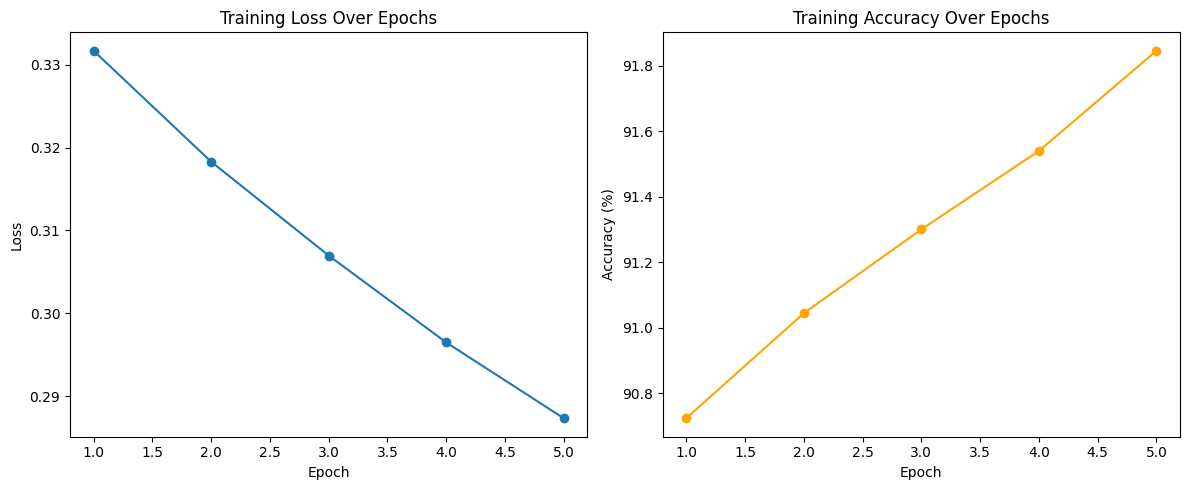

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), epoch_accuracies, marker='o', color='orange')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

---

# Step 5: Evaluate the Model on Test Data

This evaluation step is crucial for understanding the model's generalization capability and identifying areas for improvement. By calculating how many predictions match the actual labels, we can gauge the model's effectiveness.

After training a neural network model, we evaluate its performance, focusing on accuracy as a key metric -- on a dataset that it hasn't seen during training. This evaluation helps assess how well the model generalizes to new data. The provided code snippet defines a function `evaluate` for this purpose and then applies this function to compute the accuracy of `nonlinear_model` on `test_dataloader`.

### Key Components of the Evaluation Function

- **`model.eval()`**: Prepares the model for evaluation, disabling dropout and batch normalization layers to behave in inference mode.

- **`torch.no_grad()`**: Context manager that disables gradient calculation, reducing memory consumption and speeding up computations. This is useful because gradients are not needed for evaluation.

- **Loop Over DataLoader**: Iterates through the test dataset in batches, making predictions and comparing them to the actual labels to determine the number of correct predictions.

- **Accuracy Calculation**: Computes the accuracy of the model as the percentage of correct predictions out of the total number of samples in the test dataset.




In [17]:
def evaluate(dataloader, model, loss_fn):
    # Switch the model to evaluation mode
    model.eval()

    # Initialize counters for total and correct predictions
    total, correct = 0, 0

    # Disable gradient computation during evaluation
    with torch.no_grad():
        for X, y in dataloader:
            # Make predictions for the batch
            pred = model(X)
            # Update total count of samples
            total += y.size(0)
            # Update correct prediction count
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate and return the accuracy percentage
    accuracy = (correct / total) * 100
    return accuracy

# Compute the accuracy of the model on the test dataset
accuracy = evaluate(test_dataloader, nonlinear_model, loss_fn)

# Print the computed accuracy
print(f"Test Accuracy: {accuracy}%")


Test Accuracy: 92.05%


### We can also plot the models predictions

Visualizing actual images alongside their predicted and true labels can help identify patterns in the errors made by the model:

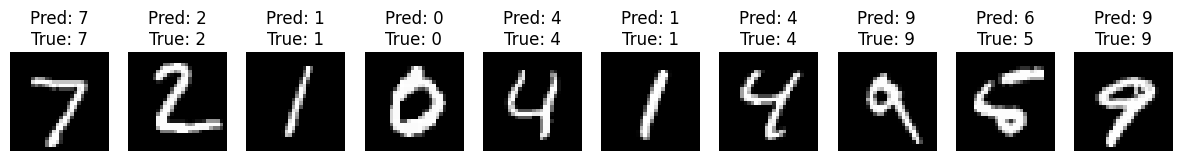

In [20]:
# Switch the model to evaluation mode
nonlinear_model.eval()

# Get a batch of test data
images, labels = next(iter(test_dataloader))

# Generate predictions for the selected batch
with torch.no_grad():  # Ensure gradient computation is disabled
    predictions = nonlinear_model(images).argmax(dim=1)

# Now proceed with the plotting, using the predictions
def plot_images_with_labels(images, labels, predictions):
    plt.figure(figsize=(15, 5))  # Adjust size as needed
    for i in range(min(len(images), 10)):  # Plot up to 10 images
        plt.subplot(1, 10, i+1)
        img = images[i].squeeze()  # Remove channel dimension for grayscale image
        plt.imshow(img.cpu().numpy(), cmap='gray')  # Assuming images are on GPU, move to CPU
        plt.title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        plt.axis('off')
    plt.show()

# Call the function to plot images with predictions and true labels
plot_images_with_labels(images, labels, predictions)


# EXTRA: Experimenting with Improvements

To improve the model, consider experimenting with:
- **Increasing Model Complexity**: Adding more layers or increasing the number of neurons in existing layers.
- **Changing Activation Functions**: Experimenting with different activation functions like LeakyReLU or ELU.
- **Adjusting the Learning Rate**: Tuning the learning rate or using learning rate schedulers.
- **Using Different Optimizers**: Trying out optimizers like Adam or RMSprop instead of SGD.
- **Implementing Regularization**: Adding dropout layers or using L2 regularization to prevent overfitting.

# Visualizing Confusion Matrix for Model Predictions
A confusion matrix can provide detailed insights into how well the model is performing across different classes. After evaluating the model on the test set, you can generate and plot a confusion matrix:

For instance, off-diagonal elements indicate misclassifications, which can inform further model tuning or data preprocessing steps

[read more](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

A confusion matrix is a table often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. It allows easy identification of confusion between classes, as well as the specific types of errors made by the classification model. Here’s a breakdown of its components for a binary classification problem, which can be extended to multi-class classification:

- **True Positives (TP)**: The cases in which the model correctly predicts the positive class.
- **True Negatives (TN)**: The cases in which the model correctly predicts the negative class.
- **False Positives (FP)**: The cases in which the model incorrectly predicts the positive class (also known as a "Type I error").
- **False Negatives (FN)**: The cases in which the model incorrectly predicts the negative class (also known as a "Type II error").

For a binary classification, the confusion matrix looks like this:

|                 | Predicted Positive | Predicted Negative |
|-----------------|--------------------|--------------------|
| **Actual Positive** | True Positive (TP)  | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN)  |

### Advantages of a Confusion Matrix

- **Comprehensive**: Provides a detailed breakdown of correct and incorrect classifications for each class.
- **Insightful**: Enables the calculation of various performance metrics, such as accuracy, precision, recall, and F1 score, which can provide more insight into the model's performance than accuracy alone.
- **Diagnostic**: Helps in diagnosing the types of errors the model is making, guiding further improvements in model training or data preprocessing.

### Extension to Multi-Class Classification

In multi-class classification scenarios, the confusion matrix is extended to include rows and columns for each class. The diagonal elements still represent the number of correct classifications for each class (true positives), while the off-diagonal elements indicate the instances where predictions were made incorrectly among different classes.

### Calculating Performance Metrics

Various performance metrics derived from the confusion matrix provide a more nuanced understanding of the model's performance:

- **Accuracy**: The proportion of total correct predictions (TP + TN) out of all predictions.
- **Precision**: The proportion of true positive predictions in the predicted positive class (TP / (TP + FP)).
- **Recall (Sensitivity)**: The proportion of true positive predictions out of all actual positive instances (TP / (TP + FN)).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between them (2 * Precision * Recall / (Precision + Recall)).

The confusion matrix is a fundamental tool in the evaluation phase of a classification model, providing a visual representation of the model's performance across different classes and facilitating the identification of patterns in the errors it makes.

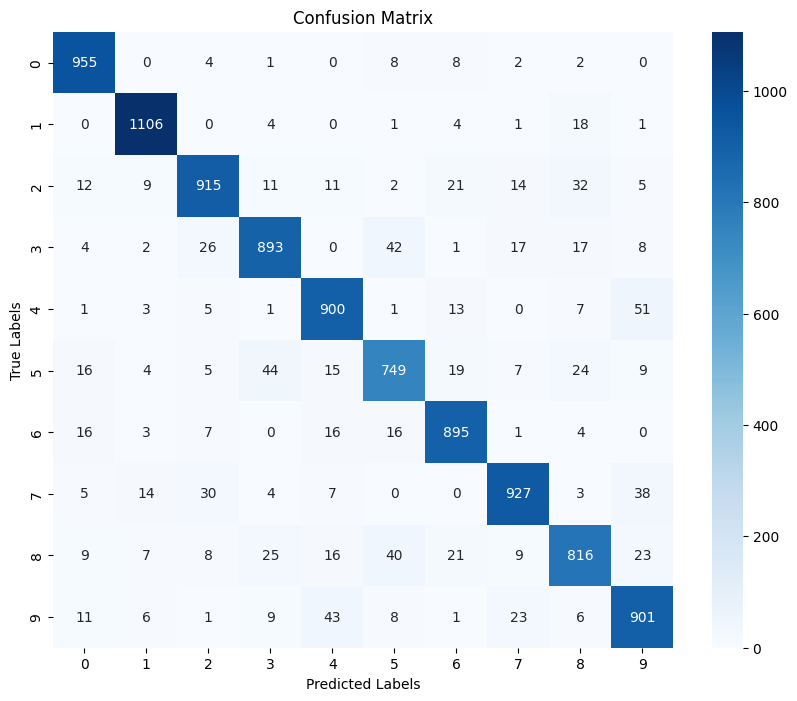

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Assuming you have a function to get all predictions and true labels from the test set
def get_all_preds_and_labels(model, dataloader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, y), dim=0)
    return all_preds.argmax(dim=1), all_labels

preds, labels = get_all_preds_and_labels(nonlinear_model, test_dataloader)
cm = confusion_matrix(labels.numpy(), preds.numpy())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
